In [34]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [35]:
background = np.load('Datasets/background.npz')['data']
bbh = np.load('Datasets/bbh_for_challenge.npy')
sglf = np.load('Datasets/sglf_for_challenge.npy')


In [36]:
background.shape, bbh.shape, sglf.shape

((100000, 2, 200), (100000, 2, 200), (100000, 2, 200))

In [37]:
bbh

array([[[ 1.03012301e+00,  6.66234931e-01,  2.75682791e-01, ...,
         -2.60990943e-01, -5.84393959e-01, -7.46497385e-01],
        [-6.27454114e-02, -1.84487786e-01,  3.88559400e-01, ...,
         -3.36276782e-01,  1.01263768e+00,  3.80964610e-01]],

       [[ 1.74979840e-01,  7.48266345e-01,  7.24211640e-01, ...,
         -4.63622030e-01,  1.05639532e-01, -5.14535730e-01],
        [-1.95504422e-01, -2.33750909e-01, -2.80466593e-01, ...,
          4.68445328e-01,  5.14595869e-01,  1.75297586e-01]],

       [[-4.33038517e-01, -6.44210364e-02, -5.06945784e-02, ...,
         -1.23892618e+00, -5.15168298e-01, -1.40534826e-01],
        [ 5.88572449e-01,  4.23104898e-01, -8.21322389e-04, ...,
          5.09951853e-01,  3.73084958e-01,  8.12072346e-01]],

       ...,

       [[ 1.23303802e+00, -2.59893629e-02,  2.84386656e-01, ...,
          2.83659281e-01,  5.65552664e-01, -3.75204062e-01],
        [-3.55021412e-01, -8.93913081e-01, -7.67647471e-01, ...,
         -1.59143451e-01, -6.23624

In [38]:
def normalize(data):
    stds = np.std(data, axis=-1, keepdims=True)
    return data / stds

background = normalize(background)
bbh = normalize(bbh)
sglf = normalize(sglf)

# Reshape for input (N, 200, 2)
background = np.swapaxes(background, 1, 2)
bbh = np.swapaxes(bbh, 1, 2)
sglf = np.swapaxes(sglf, 1, 2)

# Train-test split
x_train, x_test = train_test_split(background, test_size=0.2, random_state=42)
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (80000, 200, 2), x_test shape: (20000, 200, 2)


In [39]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
bbh = torch.tensor(bbh, dtype=torch.float32)
sglf = torch.tensor(sglf, dtype=torch.float32)

train_loader = data.DataLoader(x_train, batch_size=32, shuffle=True)
test_loader = data.DataLoader(x_test, batch_size=32)

In [42]:
class CNNAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_len, num_filters=32, kernel_size=3, ff_dim=64, dropout=0.1):
        super(CNNAutoencoder, self).__init__()
        
        self.num_filters = num_filters
        self.seq_len = seq_len

        # encoder
        self.encoder_conv1 = nn.Conv1d(input_dim, num_filters, kernel_size, padding="same")
        self.encoder_conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size, padding="same")
        self.encoder_pool = nn.MaxPool1d(kernel_size=2)  # Downsample by 2

        # latent representation
        self.latent = nn.Linear((seq_len // 2) * (num_filters * 2), ff_dim)

        # dcoder
        self.decoder_fc1 = nn.Linear(ff_dim, (seq_len // 2) * (num_filters * 2))
        self.decoder_conv1 = nn.Conv1d(num_filters * 2, num_filters, kernel_size, padding="same")
        self.decoder_conv2 = nn.Conv1d(num_filters, input_dim, kernel_size, padding="same")
        self.decoder_upsample = nn.Upsample(scale_factor=2, mode="nearest")  # Upsample by 2
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, input_dim, seq_len)
        
        # Encoder
        x = F.relu(self.encoder_conv1(x))
        x = self.dropout(x)
        x = F.relu(self.encoder_conv2(x))
        x = self.encoder_pool(x)  # downsample by 2
        
        x = x.flatten(start_dim=1)  # flatten for dense layer
        latent = F.relu(self.latent(x))

        # Decoder
        x = F.relu(self.decoder_fc1(latent)) 
        x = x.view(x.size(0), self.num_filters * 2, -1) 
        x = F.relu(self.decoder_conv1(x))
        x = self.decoder_upsample(x)  # upsample by 2
        x = self.decoder_conv2(x)  

        return x.permute(0, 2, 1)  # (batch_size, seq_len, input_dim)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
seq_len = 200
input_dim = 2
model = CNNAutoencoder(input_dim=input_dim, seq_len=seq_len).to(device)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)

        outputs = model(batch)
        loss = criterion(outputs, batch)  
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

c:\Users\siddu\anaconda3\envs\pytorch_audio\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], Loss: 0.8382
Epoch [2/50], Loss: 0.8065
Epoch [3/50], Loss: 0.7955
Epoch [4/50], Loss: 0.7866
Epoch [5/50], Loss: 0.7813
Epoch [6/50], Loss: 0.7791
Epoch [7/50], Loss: 0.7746
Epoch [8/50], Loss: 0.7728
Epoch [9/50], Loss: 0.7720
Epoch [10/50], Loss: 0.7714
Epoch [11/50], Loss: 0.7710
Epoch [12/50], Loss: 0.7707
Epoch [13/50], Loss: 0.7705
Epoch [14/50], Loss: 0.7703
Epoch [15/50], Loss: 0.7701
Epoch [16/50], Loss: 0.7700
Epoch [17/50], Loss: 0.7698
Epoch [18/50], Loss: 0.7697
Epoch [19/50], Loss: 0.7696
Epoch [20/50], Loss: 0.7695
Epoch [21/50], Loss: 0.7694
Epoch [22/50], Loss: 0.7693
Epoch [23/50], Loss: 0.7692
Epoch [24/50], Loss: 0.7691
Epoch [25/50], Loss: 0.7690
Epoch [26/50], Loss: 0.7689
Epoch [27/50], Loss: 0.7688
Epoch [28/50], Loss: 0.7687
Epoch [29/50], Loss: 0.7686
Epoch [30/50], Loss: 0.7685
Epoch [31/50], Loss: 0.7683
Epoch [32/50], Loss: 0.7682
Epoch [33/50], Loss: 0.7681
Epoch [34/50], Loss: 0.7679
Epoch [35/50], Loss: 0.7677
Epoch [36/50], Loss: 0.7674
E

In [44]:
def compute_reconstruction_errors(model, data_loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            reconstructed = model(batch)
            error = torch.mean((reconstructed - batch) ** 2, dim=(1, 2)) 
            errors.append(error.cpu().numpy())
    return np.concatenate(errors)


In [45]:
background_errors = compute_reconstruction_errors(model, test_loader, device)
bbh_errors = compute_reconstruction_errors(model, data.DataLoader(bbh, batch_size=32), device)
sglf_errors = compute_reconstruction_errors(model, data.DataLoader(sglf, batch_size=32), device)

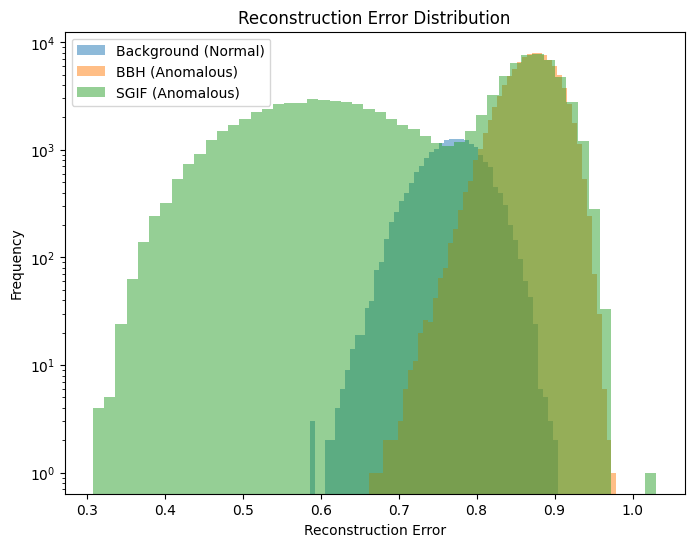

In [46]:
plt.figure(figsize=(8, 6))
plt.hist(background_errors, bins=50, alpha=0.5, label="Background (Normal)")
plt.hist(bbh_errors, bins=50, alpha=0.5, label="BBH (Anomalous)")
plt.hist(sglf_errors, bins=50, alpha=0.5, label="SGIF (Anomalous)")
plt.yscale("log")  # Log scale
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()

In [47]:
def plot_roc_curve(normal_errors, anomaly_errors, title="ROC Curve"):
    true_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
    scores = np.concatenate([normal_errors, anomaly_errors])

    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

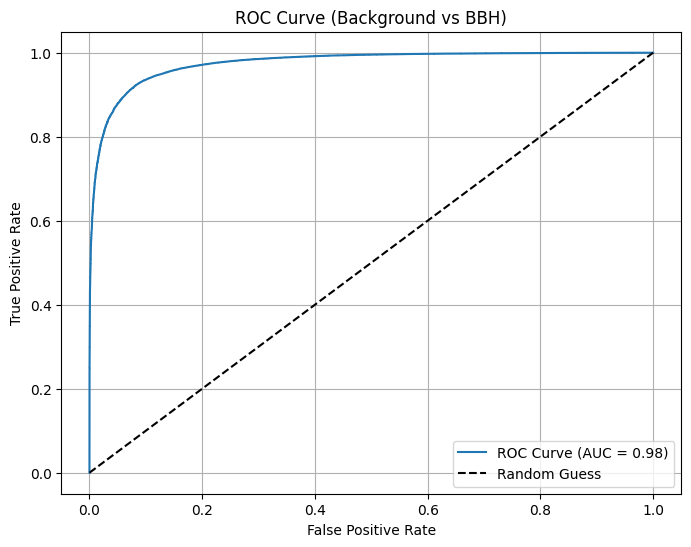

In [48]:
plot_roc_curve(background_errors, bbh_errors, title="ROC Curve (Background vs BBH)")


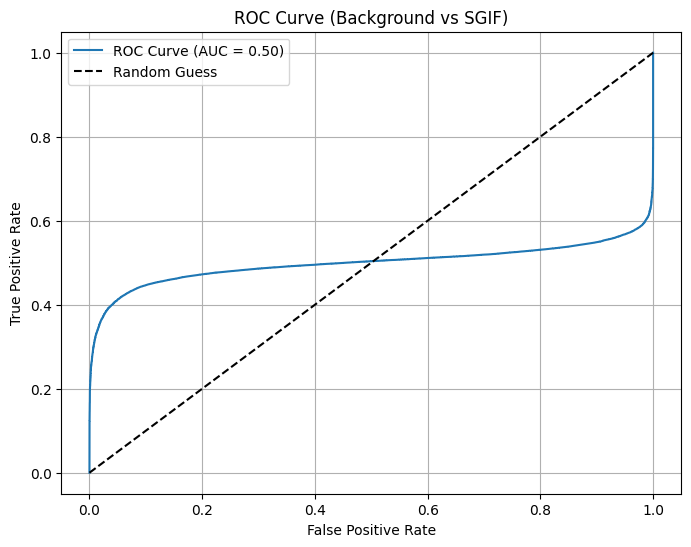

In [49]:
plot_roc_curve(background_errors, sglf_errors, title="ROC Curve (Background vs SGIF)")
